In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from hyperopt import tpe, Trials, hp

In [190]:
df = pd.read_csv('../data/shampoo.txt')

In [191]:
df = df.set_index('Month')

In [192]:
df.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


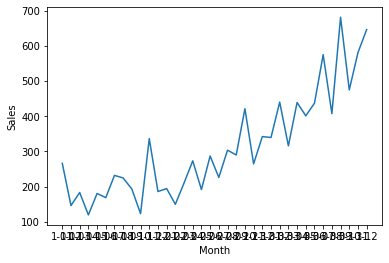

In [193]:
sns.lineplot(df.index,df.Sales)

In [194]:
series = df.Sales.tolist()

In [195]:
len(series)

36

In [196]:
def average(x):
  return [np.mean(x)]*(len(x))
average([1,2,3,4])

[2.5, 2.5, 2.5, 2.5]

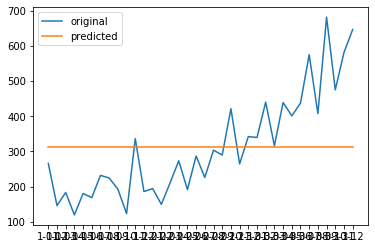

In [197]:
plt.plot(df.index, series , label='original' )
plt.plot( df.index, average(series), label = 'predicted' )
plt.legend()

In [283]:
def moving_average(x,n):
  res = [np.nan]*(n-1)
  for i in range(n,len(x)+1):
    res.append(np.mean(x[i-n:i]))
  return res

In [284]:
def moving_median(x,n):
  res = [np.nan]*(n-1)
  for i in range(n,len(x)+1):
    res.append(np.median(x[i-n:i]))
  return res

In [285]:
moving_average(np.arange(1,7), 3)

[nan, nan, 2.0, 3.0, 4.0, 5.0]

In [286]:
# moving_median(np.arange(1,7), 3)

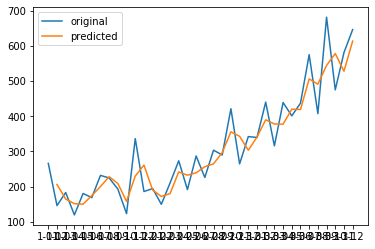

In [202]:
plt.plot(df.index, series , label='original' )
plt.plot( df.index, moving_average(series,2), label = 'predicted' )
plt.legend()

In [203]:
def double_moving_average(series ,n ):
  res = moving_average(series,n)
  res = moving_average(res,n)
  return res

In [204]:
double_moving_average( np.arange(1,7) , 3);

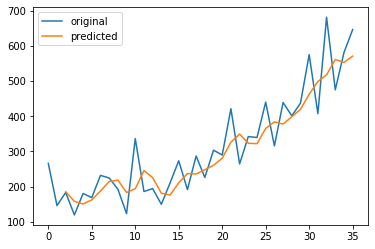

In [205]:
plt.plot( series , label='original' )
plt.plot(  double_moving_average(series ,2), label = 'predicted' )
plt.legend()

In [210]:
def single_exponential_smoothing(x , a):
  res = [ np.nan , x[0]]
  for i in range( 2 , len(x) ):
    res.append( a*x[i-1] + (1-a)*res[i-1] )
  return res

In [211]:
single_exponential_smoothing(np.arange(1,7), 0.99 )

[nan, 1, 1.99, 2.9898999999999996, 3.989899, 4.98989899]

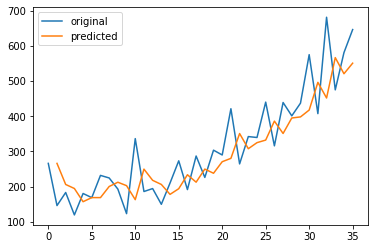

In [215]:
plt.plot( series , label='original' )
plt.plot(  single_exponential_smoothing(series ,a=0.5), label = 'predicted' )
plt.legend()

In [216]:
# !pip install statsmodels

In [217]:
def double_exponential_smoothing(x , a=0.5, g=0.5 ):
  res = [x[0]]
  s = [x[0]]
  b = [np.mean(np.sum(x[1:4]) - np.sum(x[0:3]) )]
#   b = [x[1]-x[0]]
  for t in range(1,len(x)+1):
    if t>=len(x):
        s.append( a*x[t-1] + ( 1 - a )*( s[t-1] + b[t-1] ) )
        b.append( g*(s[t-1] - s[t-1]) + (1-g)*(b[t-1]) )
    else:
        s.append(a*x[t] + (1-a)*( s[t-1]+b[t-1] ) )
        b.append( g*(s[t] - s[t-1]) + (1-g)*(b[t-1]) )
        res.append(s[t]+b[t])
  return s, res

In [218]:
def double_exponential_smoothing_2(series, alpha=0.5, beta=0.5):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            if len(series)>4:
                level, trend = series[0], np.mean(np.sum(series[1:4]) - np.sum(series[0:3]) )
            else:
                level, trend = series[0], series[1] - series[0]
#             print(trend)
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [278]:
y = double_exponential_smoothing(x,0.7,0.3)[0]

In [279]:
len(y[:-1])

7

In [282]:
x = [ 1, 2, 3, 4, 5, 6 , 1  ]
print( x )
print(double_exponential_smoothing(x,**best)[0])
# print(double_exponential_smoothing_2(x,0.7,0.3))

[1, 2, 3, 4, 5, 6, 1]
[1, 2.0000159631353718, 3.000007527459714, 4.000003549466602, 5.000001673700508, 6.000000789209676, 1.0000482615467177, 0.9999828500183228]


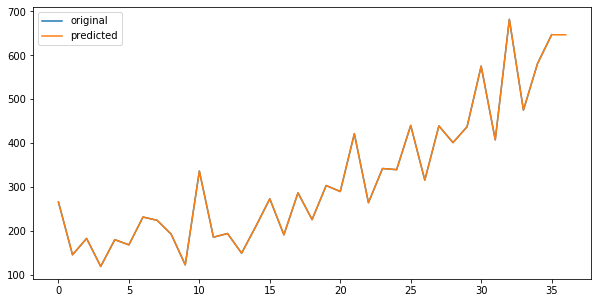

In [280]:
figure = plt.figure(figsize=(10,5))
plt.plot(series , label='original' )
plt.plot(double_exponential_smoothing( series , **best)[0] , label = 'predicted' )
# plt.plot( df.index , double_exponential_smoothing( series , 0.9 , 0.1 )[1] , label = 'predicted+1' )
plt.legend()

In [281]:
best

{'a': 0.999992018432314, 'g': 0.5284594914010886}

In [221]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [222]:
# model = ExponentialSmoothing()

In [223]:
from scipy.signal import correlate

In [224]:
correlate(series, series )

array([ 172075.4 ,  249008.51,  329688.86,  434369.47,  480937.99,
        607940.37,  689905.07,  807590.23,  877954.55,  902597.47,
       1095734.24, 1141597.86, 1192449.92, 1245793.67, 1312662.05,
       1438249.5 , 1475653.75, 1564878.23, 1668895.85, 1709829.4 ,
       1895211.56, 2005767.77, 2097504.93, 2156042.72, 2333357.46,
       2488043.08, 2561645.49, 2693905.83, 2848175.28, 2979734.54,
       3222279.01, 3332740.89, 3560861.45, 3756928.5 , 3844618.02,
       4294255.12, 3844618.02, 3756928.5 , 3560861.45, 3332740.89,
       3222279.01, 2979734.54, 2848175.28, 2693905.83, 2561645.49,
       2488043.08, 2333357.46, 2156042.72, 2097504.93, 2005767.77,
       1895211.56, 1709829.4 , 1668895.85, 1564878.23, 1475653.75,
       1438249.5 , 1312662.05, 1245793.67, 1192449.92, 1141597.86,
       1095734.24,  902597.47,  877954.55,  807590.23,  689905.07,
        607940.37,  480937.99,  434369.47,  329688.86,  249008.51,
        172075.4 ])

In [225]:
len(series)

36

In [227]:
from sklearn import datasets
from sklearn.metrics import r2_score, accuracy_score , mean_squared_error, log_loss, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from hyperopt import tpe , hp, Trials , fmin , STATUS_OK , space_eval
import warnings
from functools import partial
warnings.filterwarnings('ignore')

In [276]:
#######################################################
def compute_cost_cross(args,X):
    y = double_exponential_smoothing(X, **args)[0][:-1]
    loss = mean_squared_error( X,y )   
    return loss

In [277]:
cost = partial(compute_cost_cross , X=[1,2,3,4,5,6,1])

In [274]:
best = fmin(cost,
    {'a':hp.uniform('a', 0,1 ) , 'g':hp.uniform('g', 0,1) },
    algo=tpe.suggest,
    max_evals=1000,
    trials=Trials())

100%|██████████| 1000/1000 [00:11<00:00, 85.37it/s, best loss: 3.795262958133392e-10] 


In [275]:
print(best)

{'a': 0.999992018432314, 'g': 0.5284594914010886}


In [235]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK

def objective(x):
    return {'loss': x ** 2, 'status': STATUS_OK }

best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100)

print (best)

100%|██████████| 100/100 [00:00<00:00, 290.23it/s, best loss: 2.6044321567425076e-06]
{'x': -0.0016138253179147077}


In [236]:
best

{'x': -0.0016138253179147077}